In [1]:

import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import time
import pickle

from concurrent.futures import ProcessPoolExecutor, as_completed

import discretize
# from simpeg import dask
from simpeg.utils import mkvc, plot_1d_layer_model
from simpeg import (
    maps,
    Data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)
from simpeg.electromagnetics import time_domain as tdem
from simpeg.utils.solver_utils import get_default_solver

from simpeg.meta import MultiprocessingMetaSimulation #DaskMetaSimulation


In [28]:
Solver = get_default_solver()

In [2]:
directory = "./synthetic-data-10m"
files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.split(".")[-1]=="txt"]

files.remove("rx_locs.txt")
rx_locs = np.loadtxt(f"{directory}/rx_locs.txt")
rx_locs[:, 1] = 0.1

files.remove("rx_times.txt")
rx_times = np.loadtxt(f"{directory}/rx_times.txt")


In [3]:
dobs_dict = {}

for f in files:
    key = f.split(".")[0]
    dobs_dict[key] = np.loadtxt(f"{directory}/{f}")
    
data_dict = {}
for key, value in dobs_dict.items():
    source_list = []
    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times, orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    full_survey = tdem.Survey(source_list)

    data_dict[key] = Data(survey=full_survey, dobs=value)

n_times_invert = 20


data_dict_invert = {}

for key, value in dobs_dict.items():

    source_list = []

    for i in range(rx_locs.shape[0]):
        rx = tdem.receivers.PointMagneticFluxTimeDerivative(rx_locs[i, :], rx_times[:n_times_invert], orientation="z")
        src = tdem.sources.CircularLoop(
            receiver_list=[rx], location=rx_locs[i, :], orientation="z", radius=10,
            waveform=tdem.sources.StepOffWaveform()
        )
        source_list.append(src)

    survey = tdem.Survey(source_list)

    data_dict_invert[key] = Data(
        survey=survey,
        dobs=(value.reshape(rx_locs.shape[0], len(rx_times))[:, :n_times_invert]).flatten(),
        relative_error=0.1,
        noise_floor=1e-11
    )


In [4]:
data_invert = data_dict_invert["target_0"]

In [36]:
mesh = discretize.load_mesh(f"{directory}/treemesh.json")

active_cells_map = maps.InjectActiveCells(mesh, mesh.cell_centers[:, 2]<0, value_inactive=np.log(1e-8))
survey = data_invert.survey

refine_depth = -120
# def get_local_mesh(src):
mesh_list = []
x1 = np.mean(rx_locs[:, 0]) - (np.sum(mesh.h[0]) / 2)
x2 = np.mean(rx_locs[:, 1]) - (np.sum(mesh.h[1]) / 2)
x3 = np.mean(rx_locs[:, 2]) - (np.sum(mesh.h[2]) / 2)

for src in survey.source_list:
# src = survey.source_list[0]
    mesh_local = discretize.TreeMesh(mesh.h, origin=mesh.origin, diagonal_balance=True)
    refine_points = discretize.utils.ndgrid(
        np.r_[src.location[0]],
        np.r_[src.location[1]],
        np.linspace(-refine_depth, src.location[2], 40)
    )
    mesh_local.refine_points(
        refine_points,
        level=-1,
        padding_cells_by_level=[1, 4, 6, 2],
        finalize=True,
        diagonal_balance=True
    )
    mesh_list.append(mesh_local)
    
    mesh_local.x0



/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/discretize/utils/io_utils.py:39: FutureWarning: In discretize v1.0 the TreeMesh will change the default value of diagonal_balance to True, which will likely slightly change meshes you have previously created. If you need to keep the current behavior, explicitly set diagonal_balance=False.
  data = cls(**jsondict)


In [37]:
mesh_local

OcTreeMesh,0.00% filled
Level,Number of cells
2,16
3,336
4,320
5,400
6,650
7,1400
8,4370
9,1368
10,192


In [38]:
src = survey.source_list[0]

In [39]:
src.location

array([-5.05e+02,  1.00e-01,  3.00e+01])

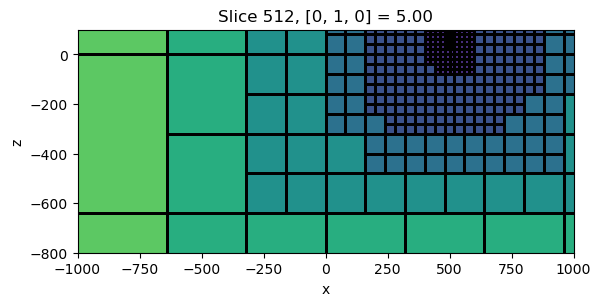

In [40]:
fig, ax = plt.subplots(1, 1)

mesh_local.plot_slice(
    np.log10(mesh_local.cell_volumes), ax=ax, normal="Y", 
    grid_opts={"color":"k", "lw":1}
)
ax.set_xlim(np.r_[-1, 1]*1000)
ax.set_ylim(np.r_[-800, 100])
ax.set_aspect(1)

In [41]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]


mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)

    local_actmap = maps.InjectActiveCells(
        local_mesh,
        active_cells=tile_map.local_active,
        value_inactive=np.log(1e-8)
    )

    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )


sim = MultiprocessingMetaSimulation(sims, mappings)

/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:229: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
/home/lheagy/miniforge3/envs/py311/lib/python3.11/site-packages/simpeg/meta/multiprocessing.py:248: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


In [42]:
src_x = np.hstack([src.location[0] for src in survey.source_list])

In [43]:
src_x2 = np.hstack([s.survey.source_list[0].location[0] for s in sim.simulations])

In [44]:
src_x

array([-505., -495., -485., -475., -465., -455., -445., -435., -425.,
       -415., -405., -395., -385., -375., -365., -355., -345., -335.,
       -325., -315., -305., -295., -285., -275., -265., -255., -245.,
       -235., -225., -215., -205., -195., -185., -175., -165., -155.,
       -145., -135., -125., -115., -105.,  -95.,  -85.,  -75.,  -65.,
        -55.,  -45.,  -35.,  -25.,  -15.,   -5.,    5.,   15.,   25.,
         35.,   45.,   55.,   65.,   75.,   85.,   95.,  105.,  115.,
        125.,  135.,  145.,  155.,  165.,  175.,  185.,  195.,  205.,
        215.,  225.,  235.,  245.,  255.,  265.,  275.,  285.,  295.,
        305.,  315.,  325.,  335.,  345.,  355.,  365.,  375.,  385.,
        395.,  405.,  415.,  425.,  435.,  445.,  455.,  465.,  475.,
        485.,  495.,  505.])

In [45]:
src_x2

array([-505., -495., -485., -475., -465., -455., -445., -435., -425.,
       -415., -405., -395., -385., -375., -365., -355., -345., -335.,
       -325., -315., -305., -295., -285., -275., -265., -255., -245.,
       -235., -225., -215., -205., -195., -185., -175., -165., -155.,
       -145., -135., -125., -115., -105.,  -95.,  -85.,  -75.,  -65.,
        -55.,  -45.,  -35.,  -25.,  -15.,   -5.,    5.,   15.,   25.,
         35.,   45.,   55.,   65.,   75.,   85.,   95.,  105.,  115.,
        125.,  135.,  145.,  155.,  165.,  175.,  185.,  195.,  205.,
        215.,  225.,  235.,  245.,  255.,  265.,  275.,  285.,  295.,
        305.,  315.,  325.,  335.,  345.,  355.,  365.,  375.,  385.,
        395.,  405.,  415.,  425.,  435.,  445.,  455.,  465.,  475.,
        485.,  495.,  505.])

In [18]:
x2

np.float64(-5119.9)

In [19]:
x3

np.float64(-5090.0)

In [20]:

mesh_local.x0=[x1, x2, x3]
# print(x1, x2, x3)

mesh_list.append(mesh_local)

# with ProcessPoolExecutor() as executor:
#     mesh_list = list(executor.map(get_local_mesh, survey.source_list))



In [ ]:
time_steps = [
    (1e-6, 30),
    (3e-6, 30),
    (1e-5, 30), (3e-5, 20), (1e-4, 20), #(3e-4, 20)
]


mappings = []
sims = []

for ii, local_mesh in enumerate(mesh_list):

    tile_map = maps.TileMap(mesh, active_cells_map.active_cells, local_mesh)
    mappings.append(tile_map)

    local_actmap = maps.InjectActiveCells(
        local_mesh,
        active_cells=tile_map.local_active,
        value_inactive=np.log(1e-8)
    )

    local_survey = tdem.Survey([survey.source_list[ii]])
    sims.append(tdem.simulation.Simulation3DElectricField(
            mesh=local_mesh,
            survey=local_survey,
            time_steps=time_steps,
            solver=Solver,
            sigmaMap=maps.ExpMap() * local_actmap
        )
    )
